In [2]:
from loss import *
from unet import UNet
from dataloader import *
from BaseModel import BaseModel

import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn

if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

In [3]:
from kornia.filters import SpatialGradient3d, SpatialGradient

In [4]:
data_dir = '../../Simple_Homogeneous_Moseley/'
data_csv = '../../Simple_Homogeneous_Moseley_Event0000_Continuous.csv'

training_data = dataset(data_dir,data_csv)

sample = training_data.__getitem__(90)

In [5]:
inputs = sample['wave_input'].transpose(1,0)
output = sample['wave_output'].transpose(1,0)

all_ = torch.cat((inputs,output),axis=0) # 5 inputs channels
fd = all_[2:,:,:] # keep the last three channels for the finite difference
fd.shape

torch.Size([3, 300, 300])

In [6]:
# Derivatives along x : to do two times recursively to compute dxdx
x = np.array([[-1,1]])

conv1=nn.Conv2d(1, 1, kernel_size=(2,1), stride=1, padding=1, bias=False)
conv1.weight=nn.Parameter(torch.from_numpy(x).float().unsqueeze(0).unsqueeze(0))

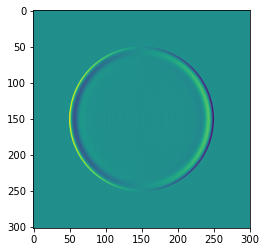

In [7]:
plt.imshow(conv1(output[None])[0,0].detach().numpy())

In [8]:
# Derivatives along y : to do two times recursively to compute dydy
y = np.array([[-1],[1]])

conv1=nn.Conv2d(1, 1, kernel_size=(2,1), stride=1, padding=1, bias=False)
conv1.weight=nn.Parameter(torch.from_numpy(y).float().unsqueeze(0).unsqueeze(0))

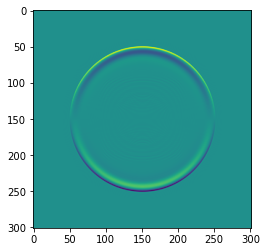

In [9]:
plt.imshow(conv1(output[None])[0,0].detach().numpy())

In [10]:
# 3D sobels --> first derivatives
x = np.array([[[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]],
              [[-2, 0, 2],
               [-4, 0, 4],
               [-2, 0, 2]],
              [[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]]
               ])

y = np.array([[[-1, -2, -1],
               [ 0,  0,  0],
               [ 1,  2,  1]],
              [[-2, -4, -2],
               [ 0,  0,  0],
               [ 2,  4,  2]],
              [[-1, -2, -1],
               [ 0,  0,  0],
               [ 1,  2,  1]]
               ])

z = np.array([[[-1, -2, -1],
               [-2, -4, -2],
               [-1, -2, -1]],
              [[ 0,  0,  0],
               [ 0,  0,  0],
               [ 0,  0,  0]],
              [[ 1,  2,  1],
               [ 2,  4,  2],
               [ 1,  2,  1]]
               ])

conv1=nn.Conv3d(3, 1, kernel_size=3, stride=1, padding=(0,1,1), bias=False)
conv1.weight=nn.Parameter(torch.from_numpy(x).float().unsqueeze(0).unsqueeze(0))

In [11]:
conv1.weight

Parameter containing:
tensor([[[[[-1.,  0.,  1.],
           [-2.,  0.,  2.],
           [-1.,  0.,  1.]],

          [[-2.,  0.,  2.],
           [-4.,  0.,  4.],
           [-2.,  0.,  2.]],

          [[-1.,  0.,  1.],
           [-2.,  0.,  2.],
           [-1.,  0.,  1.]]]]], requires_grad=True)

In [12]:
fd[None,None].shape

torch.Size([1, 1, 3, 300, 300])

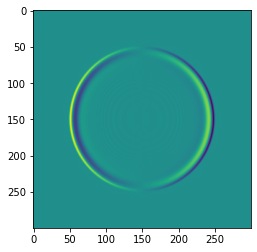

In [13]:
plt.imshow(conv1(fd[None,None])[0,0,0].detach().numpy())

## Finite difference method

In [14]:
dh = 5
dt = 0.002

c = 2200

# x FD
x = np.array([[[ 0,  0,  0],
               [ 0,  0,  0],
               [ 0,  0,  0]],
              [[ 0,  0,  0],
               [ 1, -2,  1],
               [ 0,  0,  0]],
              [[ 0,  0,  0],
               [ 0,  0,  0],
               [ 0,  0,  0]]
               ])
x = x/(dh ** 2)

# y FD
y = np.array([[[ 0,  0,  0],
               [ 0,  0,  0],
               [ 0,  0,  0]],
              [[ 0,  1,  0],
               [ 0, -2,  0],
               [ 0,  1,  0]],
              [[ 0,  0,  0],
               [ 0,  0,  0],
               [ 0,  0,  0]]
               ])

y = y/(dh ** 2)

# z FD (time)
z = np.array([[[ 0,  0,  0],
               [ 0,  1,  0],
               [ 0,  0,  0]],
              [[ 0,  0,  0],
               [ 0, -2,  0],
               [ 0,  0,  0]],
              [[ 0,  0,  0],
               [ 0,  1,  0],
               [ 0,  0,  0]]
               ])

z = z/(dt ** 2)

In [27]:
conv_x = nn.Conv3d(3, 1, kernel_size=3, stride=1, padding=(0,1,1), bias=False)
conv_x.weight=nn.Parameter(torch.from_numpy(x).float().unsqueeze(0).unsqueeze(0))
conv_x = conv_x.to(device)

conv_y = nn.Conv3d(3, 1, kernel_size=3, stride=1, padding=(0,1,1), bias=False)
conv_y.weight=nn.Parameter(torch.from_numpy(y).float().unsqueeze(0).unsqueeze(0))
conv_y = conv_y.to(device)

conv_z = nn.Conv3d(3, 1, kernel_size=3, stride=1, padding=(0,1,1), bias=False)
conv_z.weight=nn.Parameter(torch.from_numpy(z).float().unsqueeze(0).unsqueeze(0))
conv_z = conv_z.to(device)

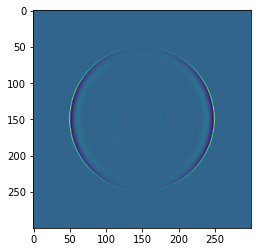

In [499]:
plt.imshow(conv_x(fd[None,None])[0,0,0].detach().numpy())

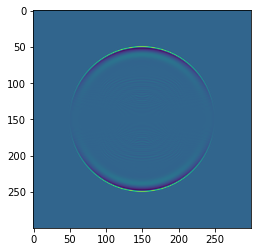

In [500]:
plt.imshow(conv_y(fd[None,None])[0,0,0].detach().numpy())

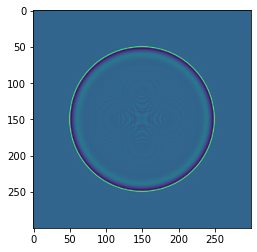

In [501]:
plt.imshow(conv_z(fd[None,None])[0,0,0].detach().numpy())

In [502]:
u_dxdx = conv_x(fd[None,None])[0,0,0].detach().numpy()
u_dydy = conv_y(fd[None,None])[0,0,0].detach().numpy()
u_dtdt = conv_z(fd[None,None])[0,0,0].detach().numpy()

In [503]:
np.linalg.norm(u_dxdx + u_dydy - u_dtdt/(c**2))

4.250314052320424

In [504]:
print('max',(u_dxdx + u_dydy - u_dtdt/(c**2)).max())

print('min',(u_dxdx + u_dydy - u_dtdt/(c**2)).min())

max 0.07611471200659253
min -0.1455873895802774


In [522]:
class PINNLoss(nn.Module):
    def __init__(self, dh=5, dt=0.002, c=2200):
        super(PINNLoss, self).__init__()

        # Parameters of the mesh
        self.dh = dh
        self.dt = dt
        self.c = c

        # Kernels filters 
        # x
        self.x = np.array([[[ 0,  0,  0],
               [ 0,  0,  0],
               [ 0,  0,  0]],
              [[ 0,  0,  0],
               [ 1, -2,  1],
               [ 0,  0,  0]],
              [[ 0,  0,  0],
               [ 0,  0,  0],
               [ 0,  0,  0]]
               ])
        self.x = self.x/(self.dh ** 2)

        # y
        self.y = np.array([[[ 0,  0,  0],
               [ 0,  0,  0],
               [ 0,  0,  0]],
              [[ 0,  1,  0],
               [ 0, -2,  0],
               [ 0,  1,  0]],
              [[ 0,  0,  0],
               [ 0,  0,  0],
               [ 0,  0,  0]]
               ])
        self.y = self.y/(self.dh ** 2)

        # z
        self.z = np.array([[[ 0,  0,  0],
               [ 0,  1,  0],
               [ 0,  0,  0]],
              [[ 0,  0,  0],
               [ 0, -2,  0],
               [ 0,  0,  0]],
              [[ 0,  0,  0],
               [ 0,  1,  0],
               [ 0,  0,  0]]
               ])
        self.z = self.z/(self.dt ** 2)

        # u_dxdx
        self.conv_x = nn.Conv3d(3, 1, kernel_size=3, stride=1, padding=(0,1,1), bias=False)
        self.conv_x.weight=nn.Parameter(torch.from_numpy(self.x).float().unsqueeze(0).unsqueeze(0))

        # u_dydy
        self.conv_y = nn.Conv3d(3, 1, kernel_size=3, stride=1, padding=(0,1,1), bias=False)
        self.conv_y.weight=nn.Parameter(torch.from_numpy(self.y).float().unsqueeze(0).unsqueeze(0))

        # u_dtdt
        self.conv_z = nn.Conv3d(3, 1, kernel_size=3, stride=1, padding=(0,1,1), bias=False)
        self.conv_z.weight=nn.Parameter(torch.from_numpy(self.z).float().unsqueeze(0).unsqueeze(0))

    def forward(self,inputs):        

        # Compute derivatives
        u_dxdx, u_dydy, u_dtdt = self.conv_x(fem_data), self.conv_y(fem_data), self.conv_z(fem_data)

        # PDE acoustic wave equation : 
        residuals = u_dxdx + u_dydy - u_dtdt * (1 / (self.c ** 2))

        return torch.norm(residuals)

In [523]:
pinn_loss = PINNLoss()